Oracle DB에 성공적으로 연결되었습니다.
훈련 세트 R²: 0.9995
테스트 세트 R²: 0.9989


C:\Users\user\AppData\Local\Temp\ipykernel_23264\1331787312.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
C:\Users\user\AppData\Local\Temp\ipykernel_23264\1331787312.py:85: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  future_df = pd.read_sql(query_future, connection)


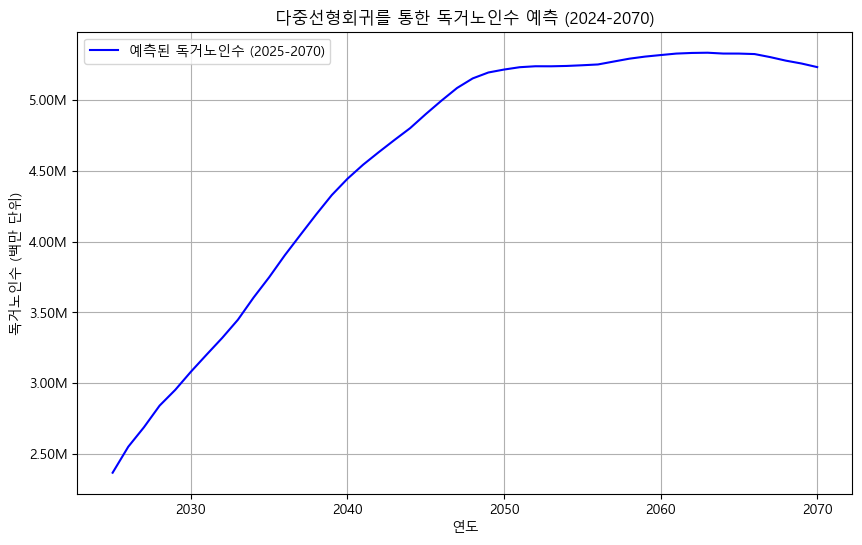

,연도,총인구,인구성장률,노인인구,노령화지수,독거노인수
0,2000,47008111,0.84,3394896,34.3,5.437870e+05
1,2005,48184561,0.21,4320787,46.8,7.455070e+05
2,2010,49554112,0.50,5366109,67.2,9.911350e+05
3,2015,51014947,0.53,6541168,93.0,1.208410e+06
4,2020,51836239,0.14,8151867,129.3,1.617739e+06
5,2025,51684564,-0.13,10513907,199.9,2.367619e+06
6,2030,51305713,-0.15,12980219,312.0,3.080727e+06
7,2035,50824868,-0.22,15208221,406.7,3.748005e+06
8,2040,50059218,-0.38,17151313,442.2,4.443099e+06
9,2045,48835031,-0.58,18235107,462.1,4.899547e+06


Oracle DB 연결이 종료되었습니다.


In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

# 한글 폰트 설정 (예: 윈도우에서 Malgun Gothic 사용)
rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 한글 폰트로 Malgun Gothic 사용
rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지지 않도록 설정

# Oracle DB 연결 (환경에 맞게 사용자명, 비밀번호, 호스트, SID 설정)
dsn_tns = cx_Oracle.makedsn('localhost', '1521', service_name='xe')  # DB 주소와 SID 설정

try:
    # DB 연결
    connection = cx_Oracle.connect(user='junbae', password='junbae', dsn=dsn_tns)
    print("Oracle DB에 성공적으로 연결되었습니다.")

    # SQL 쿼리 작성 (2000~2070년 데이터 가져오기)
    query = """
    SELECT
        연도,
        총인구,
        인구성장률,
        노인인구,
        노령화지수,
        독거노인수
    FROM
        elder_data
    WHERE
        연도 BETWEEN 2000 AND 2070
    """
    
    # SQL 실행하여 데이터프레임으로 저장
    df = pd.read_sql(query, connection)
    
    # 결측값 처리 (평균값으로 채우기)
    df.fillna(df.mean(), inplace=True)

    # X (입력 변수)와 y (타겟 변수) 정의
    features = ['총인구', '인구성장률', '노인인구', '노령화지수']
    target = '독거노인수'

    # 2000~2024년 데이터 사용 (2024년은 예측 대상)
    X = df[df['연도'] <= 2024][features]  # 2000~2024년 데이터
    y = df[df['연도'] <= 2024][target]  # 2000~2024년 독거노인수

    # 데이터 나누기 (훈련용과 테스트용)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 다중 선형 회귀 모델
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 예측 수행
    y_pred = model.predict(X_test)

    # 훈련 세트와 테스트 세트에 대한 R² 값 출력
    train_score = model.score(X_train, y_train)  # 훈련 세트에 대한 R²
    test_score = model.score(X_test, y_test)    # 테스트 세트에 대한 R²
    print(f"훈련 세트 R²: {train_score:.4f}")
    print(f"테스트 세트 R²: {test_score:.4f}")

    # 2025년부터 2070년까지 예측을 위한 데이터 생성 (2080년 → 2070년으로 변경)
    future_years = np.arange(2025, 2071)  # 2025년부터 2070년까지

    # SQL 쿼리로 2025~2070년의 총인구, 노인인구, 노령화지수 가져오기
    query_future = """
    SELECT
        연도,
        총인구,
        노인인구,
        인구성장률,
        노령화지수
    FROM
        elder_data
    WHERE
        연도 BETWEEN 2025 AND 2070
    """
    
    # SQL 실행하여 미래 데이터 가져오기
    future_df = pd.read_sql(query_future, connection)

    # 다중 선형 회귀 모델을 사용하여 예측
    future_predictions = model.predict(future_df[features])

    # 예측 결과 시각화
    plt.figure(figsize=(10, 6))

    # 2025년 이후 예측 결과만 선으로 추가 (2024년 이후부터)
    plt.plot(future_years, future_predictions, label="예측된 독거노인수 (2025-2070)", color='blue', linestyle='-', zorder=2)

    plt.xlabel("연도")
    plt.ylabel("독거노인수 (백만 단위)")
    plt.title("다중선형회귀를 통한 독거노인수 예측 (2024-2070)")

    # y축을 백만 단위로 표시
    formatter = FuncFormatter(lambda x, _: f'{x/1e6:.2f}M')
    plt.gca().yaxis.set_major_formatter(formatter)

    # 그래프 설정
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2000년부터 2023년까지의 데이터에서 5년 단위로 가져오기
    df_all = df[df['연도'] <= 2024][['연도', '총인구','인구성장률' ,'노인인구', '노령화지수', '독거노인수']]
    df_all = df_all[df_all['연도'] % 5 == 0]  # 5년 단위로 필터링

    # 2024년부터 2070년까지의 예측 데이터에서 5년 단위로 가져오기 (2080년 → 2070년으로 변경)
    future_df_all = future_df[future_df['연도'] >= 2025][['연도', '총인구', '인구성장률', '노인인구', '노령화지수']]
    future_df_all = future_df_all[future_df_all['연도'] % 5 == 0]  # 5년 단위로 필터링
    
    # '독거노인수'만 예측된 값으로 대체
    future_df_all['독거노인수'] = future_predictions[future_df_all.index]

    # 2000년부터 2023년까지 데이터와 2024년 이후 예측 데이터 결합
    full_df = pd.concat([df_all, future_df_all], ignore_index=True)

    # 테이블 출력
    display(full_df)

except cx_Oracle.DatabaseError as e:
    print("데이터베이스 연결 오류:", e)

finally:
    # 연결 종료
    if connection:
        connection.close()
        print("Oracle DB 연결이 종료되었습니다.")